# This model uses the 96 dummied columns and bootstrapping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score
import datetime

In [2]:
train = pd.read_csv('./data/clean_train.csv')

test = pd.read_csv('./data/clean_test.csv')

In [3]:
len(train.columns)

97

In [4]:
len(test.columns)

95

In [5]:
train = train.drop('native-country_ Holand-Netherlands', axis =1)

In [6]:
Bootstrapping, run only once
np.random.seed(42)
train = pd.concat([train, train[train['wage_ >50K'] == 1].sample(24720-7841, replace = True)], axis=0)

In [7]:
features = list(train.columns)

In [8]:
features = features[:95]
X = train[features]
y = train['wage_ >50K']

In [9]:
train['wage_ >50K'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: wage_ >50K, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42)

In [11]:
rf = RandomForestClassifier(n_estimators = 100)

In [12]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.8520480780753308

In [13]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
#mse
((rf.predict_proba(X_train)[:,0] - y_train)**2).mean(), ((rf.predict_proba(X_test)[:,0] - y_test)**2).mean()

(0.8694360196560839, 0.7158878270482711)

In [15]:
rf.predict_proba(X_test.head())

array([[1.  , 0.  ],
       [0.6 , 0.4 ],
       [0.6 , 0.4 ],
       [1.  , 0.  ],
       [0.95, 0.05]])

In [16]:
pred_proba = [i[1] for i in rf.predict_proba(X_test)] #1 is the steps, 2 would do every 3rd value
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

0.9044308188700908

In [17]:
roc_auc_score(pred_df['true_values'],
             pred_df['pred_probs'])

0.9044308188700908

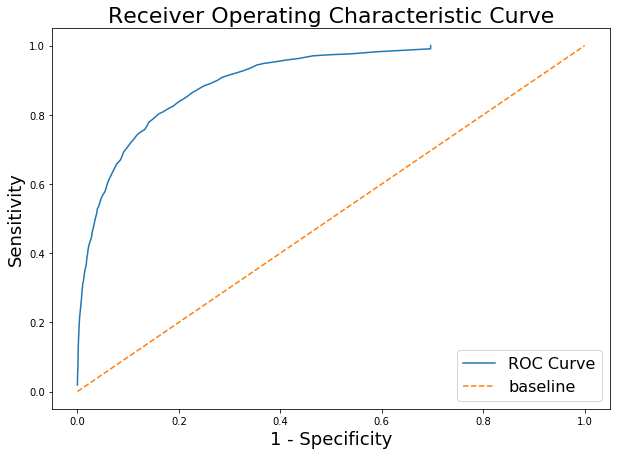

In [18]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df1, true_col, pred_prob_col, threshold):
    true_positive = df1[(df1[true_col] == 1) & (df1[pred_prob_col] >= threshold)].shape[0]
    false_negative = df1[(df1[true_col] == 1) & (df1[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df1, true_col, pred_prob_col, threshold):
    true_negative = df1[(df1[true_col] == 0) & (df1[pred_prob_col] <= threshold)].shape[0]
    false_positive = df1[(df1[true_col] == 0) & (df1[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Export

In [39]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
test_x = test[features[:95]]

In [41]:
test['wage'] = rf.predict(test_x)

In [42]:
submission = pd.DataFrame(columns = ['wage'])

In [43]:
submission['wage'] = test['wage']

In [44]:
submission.head(2)

,wage
0,0
1,0


In [47]:
timer = str(datetime.datetime.now())
f'predictions_{timer}'
submission.to_csv(f'data/team5_2.csv')

# Feature trimming through SFM

In [26]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), threshold = ("1.2*mean"))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat))

13


In [27]:
print(selected_feat)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'marital-status_ Married-civ-spouse',
       'marital-status_ Never-married', 'occupation_ Exec-managerial',
       'occupation_ Prof-specialty', 'relationship_ Not-in-family',
       'relationship_ Own-child', 'sex_ Male'],
      dtype='object')


In [28]:
sel_feats = list(selected_feat)

In [29]:
features = sel_feats
X = train[features]
y = train['wage_ >50K']

In [30]:
train['wage_ >50K'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: wage_ >50K, dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42)

In [32]:
rf = RandomForestClassifier(n_estimators = 100)

In [33]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.8450455035727213

In [34]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
#mse
((rf.predict_proba(X_train)[:,0] - y_train)**2).mean(), ((rf.predict_proba(X_test)[:,0] - y_test)**2).mean()

(0.8731478275560236, 0.7234025870337324)

In [36]:
rf.predict_proba(X_test.head())

array([[1.  , 0.  ],
       [0.73, 0.27],
       [0.46, 0.54],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [37]:
pred_proba = [i[1] for i in rf.predict_proba(X_test)] #1 is the steps, 2 would do every 3rd value
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

0.898874622130686

In [38]:
roc_auc_score(pred_df['true_values'],
             pred_df['pred_probs'])

0.898874622130686